In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import semopy
import pandas as pd

import os
from utils import *

from sklearn.decomposition import PCA

In [23]:
HOME = os.getcwd()
DATA = os.path.join(HOME, '..', 'data')
calib_mode = 'hats'

df = load_data(DATA, calib_mode, normalize=False)

dfx = df.groupby('stimulus_id').mean()    
pca = PCA()

dfy = dfx[PAQ].values
dfy = dfy - np.mean(dfy, axis=0, keepdims=True)

pca = pca.fit(dfy)
pc = pca.transform(dfx[PAQ].values)

for i in range(8):
    dfx[f'pc{i+1}'] = pc[:, i]
    
pc = pca.transform(df[PAQ].values)

for i in range(8):
    df[f'pc{i+1}'] = pc[:, i]
    
pca.mean_

array([-8.94757519e-15, -6.31593543e-15,  1.05265590e-14,  8.42124724e-15,
        1.44740187e-15, -8.28966525e-15, -2.63163976e-15,  2.89480374e-15])

In [9]:
df

,stimulus_id,chk,t,pid,pl,ch,vi,un,ca,an,...,isopl,isoev,pc1proj,pc2proj,pc3proj,pc4proj,pc5proj,pc6proj,pc7proj,pc8proj
0,1,1,79.917,2,80,50,80,0,0,0,...,0.419239,0.794975,54.686533,-107.353841,-19.054769,-15.472390,6.395194,-52.138062,17.270374,-84.406843
1,1,1,65.831,3,70,60,60,40,50,40,...,0.124264,0.141421,20.216915,-42.869765,-23.366514,-51.201943,-29.942268,-99.473641,3.598682,-87.643205
2,1,1,51.471,4,89,9,89,8,55,21,...,0.615563,0.292254,80.768008,-54.295646,-18.770293,-47.667699,-35.394784,-70.131276,33.706125,-66.780902
3,1,1,51.135,5,66,66,64,40,31,60,...,0.071716,0.351299,12.399226,-66.558117,-28.662895,-24.298907,-52.440745,-81.912410,-1.406187,-88.185179
4,1,1,42.056,6,70,70,60,60,30,60,...,-0.105025,0.087868,-10.150334,-40.808443,-40.684433,-53.562220,-32.447486,-106.953034,13.832242,-104.997073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,27,1,80.202,22,25,60,83,69,29,74,...,-0.243970,-0.037523,-28.684743,-29.292672,-64.455182,-77.593227,-58.466125,-76.292211,1.411938,-78.276195
644,27,1,64.690,23,75,40,75,40,60,35,...,0.297487,0.097487,41.674652,-37.618641,-26.897602,-61.913438,-35.336370,-92.817517,12.889554,-87.386585
645,27,1,75.361,24,43,72,61,70,24,72,...,-0.295858,-0.014680,-34.679061,-30.491396,-52.066209,-61.974062,-43.552963,-94.414718,4.766825,-94.372882
646,27,1,100.610,25,50,60,70,40,40,40,...,0.070711,0.229289,13.360901,-52.370206,-29.497436,-54.821328,-33.021202,-78.829269,-3.788495,-82.973278


In [16]:
adjacency = pd.DataFrame(np.eye(8), columns=PAQ_CCW, index=PAQ_CCW)

for i, p in enumerate(PAQ_CCW):
    for j, q in enumerate(PAQ_CCW):
        if np.abs(i - j) in [1, 7]:
            adjacency.loc[p, q] = cos45
        if np.abs(i - j) in [3, 5]:
            adjacency.loc[p, q] = -cos45
        if np.abs(i - j) == 4:
            adjacency.loc[p, q] = -1
            
adjacency

,pl,vi,ev,ch,an,mo,un,ca
pl,1.000000,0.707107,0.000000,-0.707107,-1.000000,-0.707107,0.000000,0.707107
vi,0.707107,1.000000,0.707107,0.000000,-0.707107,-1.000000,-0.707107,0.000000
ev,0.000000,0.707107,1.000000,0.707107,0.000000,-0.707107,-1.000000,-0.707107
ch,-0.707107,0.000000,0.707107,1.000000,0.707107,0.000000,-0.707107,-1.000000
an,-1.000000,-0.707107,0.000000,0.707107,1.000000,0.707107,0.000000,-0.707107
mo,-0.707107,-1.000000,-0.707107,0.000000,0.707107,1.000000,0.707107,0.000000
un,0.000000,-0.707107,-1.000000,-0.707107,0.000000,0.707107,1.000000,0.707107
ca,0.707107,0.000000,-0.707107,-1.000000,-0.707107,0.000000,0.707107,1.000000


In [18]:
semopy.efa.explore_cfa_model(df[PAQ + ['isoev', 'isopl']])

''

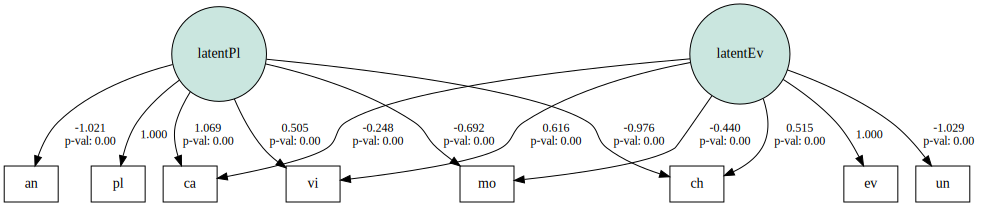

In [21]:
def make_simple_2d_model():
    model = ""
    for i, p in enumerate(PAQ_CCW):
        for q in PAQ_CCW[i:]:
        # model += f"DEFINE(ordinal) {p}\n"
            model += f"{p} ~~ {q}\n"
            # break
    
    for q in ['pl', 'ev']:
        factors = []
        for p in PAQ_CCW:
            if adjacency.loc[p, q] != 0:
                factors.append(f"1.0 * {p}" if p == q else p)
        factors = " + ".join(factors)
        model += f"latent{q.capitalize()} =~ {factors}\n"
    model += "latentPl ~~ latentEv\n"
    
    # print(model)
    
    model = semopy.Model(model, mimic_lavaan=True)
    return model

m = make_simple_2d_model()
m.fit(df, clean_slate=True)
g = semopy.semplot(m, "pd.png")#, plot_covs=True)
g

/home/kwatchar3/anaconda3/envs/satp/lib/python3.8/site-packages/semopy/polycorr.py:204: RuntimeWarning: invalid value encountered in log
  return -sum(np.log(bivariate_cdf([x_ints[i], y_ints[j]],


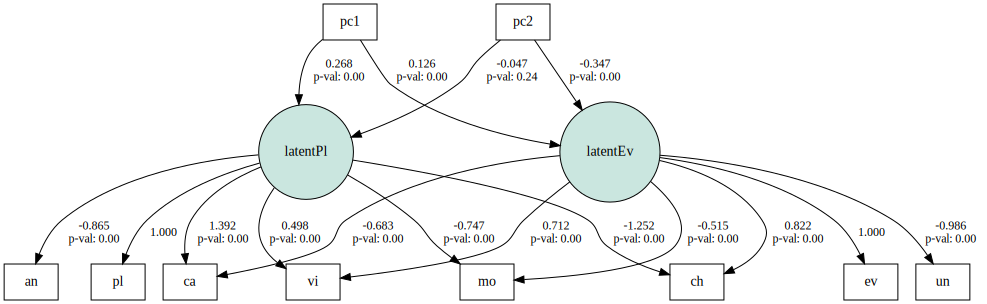

In [26]:
model = ""

for p in PAQ_CCW:
    model += f"{p} ~~ {p}\n"
    model += f"DEFINE(ordinal) {p}\n"
    
    for q in PAQ_CCW:
        if adjacency.loc[p, q] != 0:
            model += f"{p} ~~ {q}\n"

for p in ['pl', 'ev']:
    latentP = f"latent{p.capitalize()}"
    model += f"{latentP} ~ pc1 + pc2\n"
    loadings = []
    for q in PAQ_CCW:
        if adjacency.loc[p, q] != 0:
            loadings += [f"1.0 * {q}"] if p == q else [f"{q}"]
        
            
    loadings = "+".join(loadings)
    
    model += f"{latentP} =~ {loadings} \n"
    
    model += f"latentPl ~~ latentEv\n"

    
    

m = semopy.Model(model)

m.fit(df, clean_slate=True)

g = semopy.semplot(m, "pd.png")# plot_covs=True)
g

In [80]:
m.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,latentPl,~,pc1,0.337076,0.175212,1.92382,0.054377
1,latentPl,~,pc2,0.001936,0.174998,0.011061,0.991175
2,latentEv,~,pc1,0.105393,0.167908,0.627685,0.53021
3,latentEv,~,pc2,-0.403580,0.168833,-2.39041,0.01683
4,pl,~,latentPl,1.000000,-,-,-
5,vi,~,latentPl,0.556561,0.076349,7.289645,0.0
6,vi,~,latentEv,0.682399,0.079913,8.539236,0.0
7,ch,~,latentPl,-0.989439,0.061234,-16.158384,0.0
8,ch,~,latentEv,0.674282,0.058094,11.606744,0.0
9,an,~,latentPl,-0.981854,0.0845,-11.61962,0.0
